In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 0. Read-in data

In [2]:
df = pd.read_excel('RAW-DATA_machine-defects.xlsx')
df.shape

(26, 6)

In [3]:
df.head()

,Machines,Defects,Maintenance,Technicians,Age,Tool
0,1,860,26,5,6.0,18.3
1,2,890,27,2,7.0,10.2
2,3,852,20,3,5.2,14.7
3,4,889,28,3,4.3,13.1
4,5,1037,25,4,13.5,7.6


**Reorder columns to position output variable first (only for readability):**

In [4]:
columns = ['Defects', 'Machines', 'Maintenance', 'Technicians', 'Age', 'Tool']
df = df.reindex(columns=columns)

In [5]:
df.describe()

,Defects,Machines,Maintenance,Technicians,Age,Tool
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
mean,1006.961538,13.500000,22.615385,4.115385,9.738462,11.038462
std,197.388851,7.648529,3.742480,1.142871,3.810520,4.484558
min,724.000000,1.000000,15.000000,2.000000,4.300000,4.000000
25%,867.250000,7.250000,20.000000,3.000000,6.700000,7.900000
50%,974.500000,13.500000,23.500000,4.000000,8.500000,10.000000
75%,1104.000000,19.750000,25.750000,5.000000,13.575000,15.450000
max,1439.000000,26.000000,28.000000,6.000000,17.100000,18.500000


# 1. Distribution of each given feature: Histograms

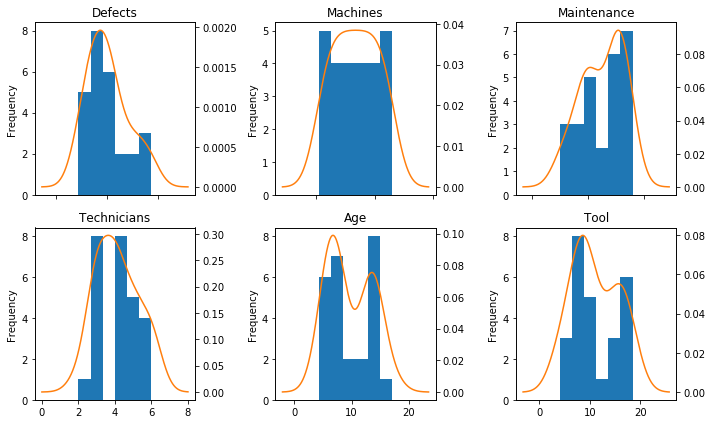

In [58]:
fig_k, ax_k = plt.subplots(2, 3, figsize=(10, 6))
i = 0
for column in df:
    ax = ax_k[i//3, i%3]
    df[column].hist(ax=ax, bins='auto', color='C0')
    df[column].plot.kde(ax=ax, secondary_y=True, color='C1')
    ax.set(title=column, ylabel='Frequency')
    i += 1
plt.tight_layout()
plt.show()

## Conclusions from feature distributions
The above distribution plots include both a histogram and Gaussian Kernel Density Estimate (KDE) plot for each feature (variable) in the dataset. A KDE (as the name implies) estimates the variable's probability density function—the continuous equivalent to a the inherently discrete histogram. 

Due to the limited sample size (26) the KDEs have very low peak densities (for context, the area under the KDE curve is 1), this means that the KDEs do *not* provide particularly reliable pictures of the population's distribusion.

*(reading from left-to-right, then top-to-bottom)*

1. **Defects:** Unimodal distribution, right skew due to an higher number of machines in the highest defect bin than would be expeted of a normal/Gaussian distribution. 
2. **Machines:** Machine number is a unique identifier for each machine, therefore the histogram of machine number frequency contains *no useful information* since each idenetifier is unique and has no inherent meaning. 
3. **Maintenance:** Potentially bimodal distribution, but centre dip could be a result of binning. Too few data points to be sure.
4. **Technicians:** Again, potentially bimodal distribution, but centre zero could be a result of binning. Too few data points to be sure (may be pseudo-normal).
5. **Age:** Likely bimodal distribution, meaning there are a group of 'new' machines and a group of 'older' machines.  
6. **Tool:** Again, likely bimodal distribuition. This means they can be grouped into one a group of machines undergoing frequent tool changes, and another group subjected to fewer toolchanges.

# 2. Determining model requirements 
## (this part might be wrong... std err. from Excel not the same as descriptive stats SE)

The model is intended to be used for prediction of the number of defective parts a machine will produce in a given year. Given that the available dataset is relatively small, it is unreasonable to expect great accuracy, from the model (i.e. a small prediction interval).

In observing the histogram for Defects per machine per year, it is apparent that the distribution is non-gaussian, being right-skew but with a rise in the number machines with high defects per year that cannot simply be considered outliers.

The model would be useful if it could at least predict whether the number of defective parts would be high or low (above or below the median), and even more useful if it could predict the quartile in which the number of defects will fall.

**These goals equate to the following standard error requirements, given a 95% confidence interval:**

In [59]:
from scipy.stats import norm
def zscore(p_confidence_interval):
    return norm.ppf(1-(1-p_confidence_interval)/2)

In [60]:
# test zscore
print(f'{zscore(0.95):.2f}') # should be 1.96

1.96


**Generate box plot of defects to visualise the distribution, mean, median, and quartile ranges of the parameter to predict (defects):**  

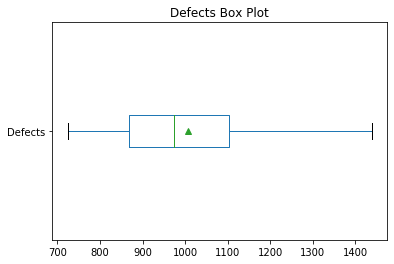

In [62]:
plt.figure()
df['Defects'].plot(kind='box', showmeans=True, vert=False, title='Defects Box Plot')
plt.show()

## 2.a. Max standard error to predict above/below median

In [63]:
'''
Here, the term "half quantile" is used to describe the breaking up 
of the probability distribution above and below the median. This is
not standard terminology, but is useful for some brevity in code. 
'''

half_quantiles = df['Defects'].quantile([0, 0.5, 1])
print(f'Half quantiles:\n{half_quantiles}\n')
half_quantile_ranges = pd.Series(np.diff(half_quantiles))
print(f'Half quantile ranges:\n{half_quantile_ranges}\n')
half_quantile_range_min = half_quantile_ranges.min()
print(f'Minimum half quantile range = {half_quantile_range_min}')

Half quantiles:
0.0     724.0
0.5     974.5
1.0    1439.0
Name: Defects, dtype: float64

Half quantile ranges:
0    250.5
1    464.5
dtype: float64

Minimum half quantile range = 250.5


In [64]:
half_quantile_min_SE_95 = (half_quantile_range_min/2)/zscore(0.95)
half_quantile_min_SE_90 = (half_quantile_range_min/2)/zscore(0.90)
print(f'Maximum standard error to predict results above/below mean to 95% CI = {half_quantile_min_SE_95:.2f}')
print(f'Maximum standard error to predict results above/below mean to 90% CI = {half_quantile_min_SE_90:.2f}')

Maximum standard error to predict results above/below mean to 95% CI = 63.90
Maximum standard error to predict results above/below mean to 90% CI = 76.15


## 2.b. Max standard error to predict quartile

In [65]:
quartiles = df['Defects'].quantile([0, 0.25, 0.5, 0.75, 1])
print(f'Quartiles:\n{quartiles}\n')
quartile_ranges = pd.Series(np.diff(quartiles))
print(f'Quartile ranges:\n{quartile_ranges}\n')
quartile_range_min = quartile_ranges.min()
print(f'Minimum quartile range = {quartile_range_min}')

Quartiles:
0.00     724.00
0.25     867.25
0.50     974.50
0.75    1104.00
1.00    1439.00
Name: Defects, dtype: float64

Quartile ranges:
0    143.25
1    107.25
2    129.50
3    335.00
dtype: float64

Minimum quartile range = 107.25


In [66]:
quartile_min_SE_95 = (quartile_range_min/2)/zscore(0.95)
quartile_min_SE_90 = (quartile_range_min/2)/zscore(0.90)
print(f'Maximum standard error to predict quartile to 95% CI = {quartile_min_SE_95:.2f}')
print(f'Maximum standard error to predict quartile to 90% CI = {quartile_min_SE_90:.2f}')

Maximum standard error to predict quartile to 95% CI = 27.36
Maximum standard error to predict quartile to 90% CI = 32.60


# 3. Correlation analysis: Initial scatter plots of each feature vs. Defects

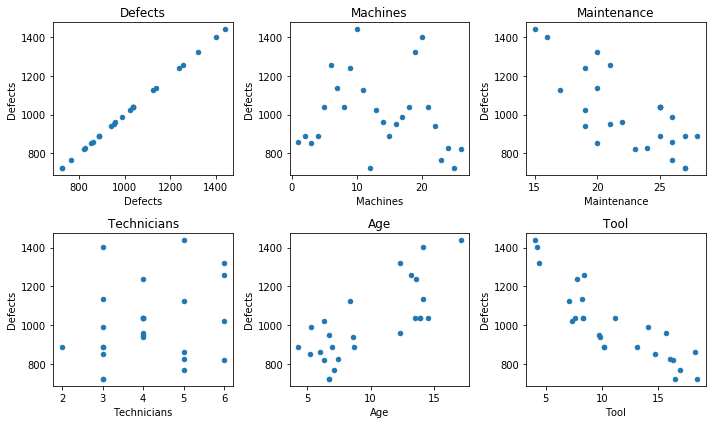

In [67]:
fig_s, ax_s = plt.subplots(2, 3, figsize=(10, 6))
i = 0
for column in df:
    df.plot(x=column, y='Defects', kind='scatter', ax=ax_s[i//3, i%3], title=column)
    i += 1
plt.tight_layout()
plt.show()

## Conclusions from initial scatter plots:

The above scatter plots show the ...

*(reading from left-to-right, then top-to-bottom)*

1. **Defects:** Ignore, plot is simply a result of convenience for the loop.
2. **Machines:** The machine number is ***not correlated*** with the number of yearly defects. This is expected as machine number is an effectively random assignment and has no meaning other than being a unique identifier.
3. **Maintenance:** The number of maintenance operations performed is ***somewhat negatively correlated*** with the number of yearly defects. This makes sense as one would expect more frequently maintained machines to produce fewer defective parts.
4. **Technicians:** The number of technicians responsible for a machine appears to have ***no clear correlation*** with the number of yearly defects. It is possible on a larger sample set may show a stronger correlation, but this sample of 26 does not.
5. **Age:** The age of a machine is ***somewhat positively correlated*** with the number of yearly defects. This, again seems reasonable as one would expect older machines to perform more poorly.
6. **Tool:** The average number of tool changes per month performed by a machine is quite ***strongly negatively correlated*** with the number of yearly defects (Defects). This suggests that the longer a tool is in use, the more frequently it produces defective parts. This leads to the hypothesis that potentially an inverse relationship exists, supported by the fact that the correlation appears to potentially be non-linear (although difficult to tell given the small sample set).


In [69]:
df['inv_Tool'] = 1/df['Tool']

In [70]:
df['ln_Tool'] = np.log(df['Tool'])

In [71]:
df['inv_Maintenance'] = 1/df['Maintenance']

In [72]:
df['ln_Maintenance'] = np.log(df['Maintenance'])

In [73]:
df['inv_Age'] = 1/df['Age']

In [74]:
df['ln_Age'] = np.log(df['Age'])

In [75]:
df['sqrt_Age'] = np.sqrt(df['Age'])

In [76]:
df = df[['Defects', 
         'Tool', 'inv_Tool', 'ln_Tool', 
         'Age', 'ln_Age', 'sqrt_Age', 
         'Maintenance', 'inv_Maintenance', 'ln_Maintenance', 
         'Technicians', 
         'Machines'
        ]]

In [77]:
df.corr()

,Defects,Tool,inv_Tool,ln_Tool,Age,ln_Age,sqrt_Age,Maintenance,inv_Maintenance,ln_Maintenance,Technicians,Machines
Defects,1.000000,-0.866531,0.902879,-0.907643,0.759517,0.726426,0.745584,-0.735451,0.754281,-0.746714,0.258720,-0.150556
Tool,-0.866531,1.000000,-0.894025,0.975437,-0.661026,-0.650414,-0.657848,0.654897,-0.663738,0.661534,-0.138259,0.138308
inv_Tool,0.902879,-0.894025,1.000000,-0.970211,0.651959,0.627428,0.641048,-0.712344,0.758901,-0.737157,0.217170,-0.032266
ln_Tool,-0.907643,0.975437,-0.970211,1.000000,-0.675831,-0.659516,-0.669459,0.701614,-0.728402,0.716981,-0.188828,0.093670
Age,0.759517,-0.661026,0.651959,-0.675831,1.000000,0.989760,0.997610,-0.433960,0.438952,-0.435968,0.127530,-0.042134
ln_Age,0.726426,-0.650414,0.627428,-0.659516,0.989760,1.000000,0.997227,-0.433014,0.426120,-0.429229,0.150710,0.010454
sqrt_Age,0.745584,-0.657848,0.641048,-0.669459,0.997610,0.997227,1.000000,-0.433401,0.432330,-0.432459,0.138176,-0.017822
Maintenance,-0.735451,0.654897,-0.712344,0.701614,-0.433960,-0.433014,-0.433401,1.000000,-0.985632,0.996590,-0.344584,-0.020961
inv_Maintenance,0.754281,-0.663738,0.758901,-0.728402,0.438952,0.426120,0.432330,-0.985632,1.000000,-0.996188,0.291932,0.003154
ln_Maintenance,-0.746714,0.661534,-0.737157,0.716981,-0.435968,-0.429229,-0.432459,0.996590,-0.996188,1.000000,-0.318973,-0.011323


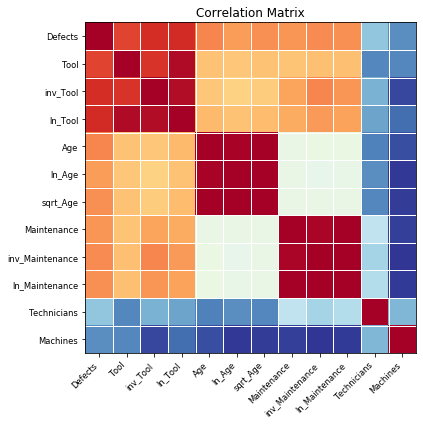

In [78]:
import statsmodels.graphics.api as smg
fig, ax = plt.subplots(figsize=(8, 6))
fig = smg.plot_corr(np.abs(df.corr()), xnames=df.columns, ax=ax)
plt.show()

| Feature | Correlation to Defects<br>& best transformation |
|:--|:--|
|Tool|Linear correlation good<br>ln(Tool) best|
|Age|Linear correlation good<br>no transformation better|
|Maintenance|Linear correlation good<br>inv(Maintenance) best|
|Technicians|not correlated|
|Machines|not correlated|

In [79]:
models_features = [
    ['Tool'],
    ['ln_Tool'],
    ['ln_Tool', 'Age', 'inv_Maintenance'],
    ['ln_Tool', 'Age', 'Maintenance'],
    ['ln_Tool', 'Age'],
]
n_models = len(models_features)

In [80]:
import statsmodels.api as sm

In [81]:
y = {}
X = {}
mod = {}
res = {}
y_pred = {}
for (i, model_features) in enumerate(models_features):
    y[i] = df['Defects']
    X[i] = df[model_features]
    X[i].insert(0, 'Intercept', 1) # add intercept feature
    
    mod[i] = sm.OLS(y[i], X[i]) # Ordinary Least Squares linear regression
    res[i] = mod[i].fit()
    
    y_pred[i] = res[i].predict(X[i])

In [82]:
# models_index = range(n_models)
models_columns = [
    'features',
    'y', 
    'y_pred', 
    'X', 
    'model', 
    'results',
    'Adj R-squared',
    'Prob (F-statistic)',
    'MSE Model',
    'MSE Residuals',
    'RMSE Residuals',
    'MSE Total',
    'AIC',
    'BIC',
    'BSE',
    'HC0_se',
    'Condition Number',
]
# models = pd.DataFrame(index=models_index, columns=models_columns)
models = pd.DataFrame(columns=models_columns)

for (i, model_features) in enumerate(models_features):
    y = df['Defects']
    X = df[model_features]
    X.insert(0, 'Intercept', 1) # add intercept feature
    
    model = sm.OLS(y, X) # Ordinary Least Squares linear regression
    results = model.fit()
    
    y_pred = results.predict(X)
    
    # store
#     models.loc[i] = {
    models.loc[f'Model {i}'] = {
        'features': model_features,
        'y': y,
        'y_pred': y_pred,
        'X': X,
        'model': model,
        'results': results,
        'Adj R-squared': results.rsquared_adj,
        'Prob (F-statistic)': results.f_pvalue,
        'MSE Model': results.mse_model,
        'MSE Residuals': results.mse_resid,
        'RMSE Residuals': np.sqrt(results.mse_resid),
        'MSE Total': results.mse_total,
        'AIC': results.aic,
        'BIC': results.bic,
        'BSE': results.bse,
        'HC0_se': results.HC0_se,
        'Condition Number': results.condition_number,
    }

In [83]:
models

,features,y,y_pred,X,model,results,Adj R-squared,Prob (F-statistic),MSE Model,MSE Residuals,RMSE Residuals,MSE Total,AIC,BIC,BSE,HC0_se,Condition Number
Model 0,[Tool],0 860 1 890 2 852 3 889 4 ...,0 730.002509 1 1038.940918 2 867...,Intercept Tool 0 1 18.3 1 ...,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,0.740495,1.049881e-08,731396.866677,10110.920619,100.553074,38962.358462,315.459349,317.975542,Intercept 53.284459 Tool 4.484414 ...,Intercept 56.768776 Tool 4.300580 ...,32.302487
Model 1,[ln_Tool],0 860 1 890 2 852 3 889 4 ...,0 769.849544 1 1002.713230 2 857...,Intercept ln_Tool 0 1 2.90690...,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,0.816475,1.575779e-10,802445.085598,7150.578164,84.561091,38962.358462,306.452354,308.968547,Intercept 88.504913 ln_Tool 37.607136 ...,Intercept 67.015309 ln_Tool 28.045214 ...,14.759690
Model 2,"[ln_Tool, Age, inv_Maintenance]",0 860 1 890 2 852 3 889 4 ...,0 770.453308 1 916.830718 2 873...,Intercept ln_Tool Age inv_Maintenance...,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,0.872729,1.274516e-10,288321.820256,4958.795490,70.418715,38962.358462,298.673269,303.705655,Intercept 243.640042 ln_Tool ...,Intercept 185.697375 ln_Tool ...,1907.588713
Model 3,"[ln_Tool, Age, Maintenance]",0 860 1 890 2 852 3 889 4 ...,0 766.010901 1 913.754101 2 876...,Intercept ln_Tool Age Maintenance 0 ...,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,0.871411,1.426522e-10,287945.446343,5010.119205,70.782196,38962.358462,298.940987,303.973373,Intercept 143.083901 ln_Tool 54.1...,Intercept 88.680337 ln_Tool 36.436...,263.378366
Model 4,"[ln_Tool, Age]",0 860 1 890 2 852 3 889 4 ...,0 765.249973 1 965.413221 2 823...,Intercept ln_Tool Age 0 1 2...,<statsmodels.regression.linear_model.OLS objec...,<statsmodels.regression.linear_model.Regressio...,0.851205,1.170345e-10,420359.495476,5797.390026,76.140594,38962.358462,301.891384,305.665674,Intercept 147.888148 ln_Tool 45.94256...,Intercept 92.813255 ln_Tool 27.709463 ...,110.393154


In [84]:
from IPython.display import display
for i, model in models.iterrows():
    print(f'Model {i}\nFeatures: ', end='')
    print(*model['features'], sep=', ')
    display(model['results'].summary())

Model Model 0
Features: Tool


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Defects   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     72.34
Date:                Wed, 22 Apr 2020   Prob (F-statistic):           1.05e-08
Time:                        14:25:53   Log-Likelihood:                -155.73
No. Observations:                  26   AIC:                             315.5
Df Residuals:                      24   BIC:                             318.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1427.9745     53.284     26.799      0.000    1318.001    1537.948
Tool         -38.1405      4.484     -8.505      0.000     -47.396     -28.885
==============================================================================
Omnibus:                        4.268   Durbin-Watson:                   2.265
Prob(Omnibus):                  0.118   Jarque-Bera (JB):                1.630
Skew:                           0.150   Prob(JB):                        0.443
Kurtosis:                       1.811   Cond. No.                         32.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Model Model 1
Features: ln_Tool


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Defects   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     112.2
Date:                Wed, 22 Apr 2020   Prob (F-statistic):           1.58e-10
Time:                        14:25:53   Log-Likelihood:                -151.23
No. Observations:                  26   AIC:                             306.5
Df Residuals:                      24   BIC:                             309.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1927.9270     88.505     21.783      0.000    1745.262    2110.592
ln_Tool     -398.3890     37.607    -10.593      0.000    -476.006    -320.772
==============================================================================
Omnibus:                        1.884   Durbin-Watson:                   2.312
Prob(Omnibus):                  0.390   Jarque-Bera (JB):                1.556
Skew:                           0.452   Prob(JB):                        0.459
Kurtosis:                       2.213   Cond. No.                         14.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Model Model 2
Features: ln_Tool, Age, inv_Maintenance


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Defects   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     58.14
Date:                Wed, 22 Apr 2020   Prob (F-statistic):           1.27e-10
Time:                        14:25:53   Log-Likelihood:                -145.34
No. Observations:                  26   AIC:                             298.7
Df Residuals:                      22   BIC:                             303.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1161.9844    243.640      4.769      0.000     656.706    1667.263
ln_Tool          -237.8310     56.035     -4.244      0.000    -354.040    -121.622
Age                15.1089      5.043      2.996      0.007       4.651      25.567
inv_Maintenance  5438.3328   2459.403      2.211      0.038     337.844    1.05e+04
==============================================================================
Omnibus:                        5.815   Durbin-Watson:                   2.152
Prob(Omnibus):                  0.055   Jarque-Bera (JB):                4.381
Skew:                           0.994   Prob(JB):                        0.112
Kurtosis:                       3.305   Cond. No.                     1.91e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.91e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Model Model 3
Features: ln_Tool, Age, Maintenance


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Defects   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     57.47
Date:                Wed, 22 Apr 2020   Prob (F-statistic):           1.43e-10
Time:                        14:25:53   Log-Likelihood:                -145.47
No. Observations:                  26   AIC:                             298.9
Df Residuals:                      22   BIC:                             304.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1692.9990    143.084     11.832      0.000    1396.261    1989.737
ln_Tool      -247.0720     54.159     -4.562      0.000    -359.391    -134.753
Age            14.7629      5.055      2.920      0.008       4.279      25.247
Maintenance   -11.4366      5.324     -2.148      0.043     -22.478      -0.395
==============================================================================
Omnibus:                        5.221   Durbin-Watson:                   2.178
Prob(Omnibus):                  0.074   Jarque-Bera (JB):                3.898
Skew:                           0.942   Prob(JB):                        0.142
Kurtosis:                       3.221   Cond. No.                         263.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Model Model 4
Features: ln_Tool, Age


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Defects   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     72.51
Date:                Wed, 22 Apr 2020   Prob (F-statistic):           1.17e-10
Time:                        14:25:53   Log-Likelihood:                -147.95
No. Observations:                  26   AIC:                             301.9
Df Residuals:                      23   BIC:                             305.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1607.8290    147.888     10.872      0.000    1301.899    1913.759
ln_Tool     -318.6100     45.943     -6.935      0.000    -413.649    -223.571
Age           13.9315      5.422      2.569      0.017       2.715      25.148
==============================================================================
Omnibus:                        0.969   Durbin-Watson:                   2.538
Prob(Omnibus):                  0.616   Jarque-Bera (JB):                0.965
Skew:                           0.350   Prob(JB):                        0.617
Kurtosis:                       2.368   Cond. No.                         110.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [85]:
tstats = {}
for i, model in models.iterrows():
    tstats[i] = model['results'].tvalues
df_tstats = pd.DataFrame(tstats)
df_tstats = df_tstats.replace(np.nan, '', regex=True)
df_tstats

,Model 0,Model 1,Model 2,Model 3,Model 4
Age,,,2.99616,2.92029,2.56942
Intercept,26.7991,21.7833,4.76927,11.8322,10.8719
Maintenance,,,,-2.14805,
Tool,-8.50513,,,,
inv_Maintenance,,,2.21124,,
ln_Tool,,-10.5934,-4.24433,-4.56196,-6.93496


In [86]:
from statsmodels.iolib.summary2 import summary_col

summary_col(
    models['results'].to_list(), 
    stars=True, 
    float_format='%.2f', 
    info_dict={
        'Adj. R2': lambda x: f'{x.rsquared_adj:.3f}',
        'Prob(F-stat)': lambda x: f'{x.f_pvalue:.2e}',
        'MSE Residuals': lambda x: f'{x.mse_resid:.1f}',
        'RMSE Residuals': lambda x: f'{np.sqrt(x.mse_resid):.1f}',
        'Condition No.': lambda x: f'{x.condition_number:.1f}',
#         't-values': lambda x: x.tvalues.to_string(),
    })

,Defects I,Defects II,Defects III,Defects IIII,Defects IIIII
Age,,,15.11***,14.76***,13.93**
,,,(5.04),(5.06),(5.42)
Intercept,1427.97***,1927.93***,1161.98***,1693.00***,1607.83***
,(53.28),(88.50),(243.64),(143.08),(147.89)
Maintenance,,,,-11.44**,
,,,,(5.32),
Tool,-38.14***,,,,
,(4.48),,,,
inv_Maintenance,,,5438.33**,,
,,,(2459.40),,


In [87]:
models[[
    'features',
    'Adj R-squared', 
    'Prob (F-statistic)', 
    'MSE Residuals',
    'RMSE Residuals',
#     'AIC',
#     'BIC',
    'Condition Number',
]].T

,Model 0,Model 1,Model 2,Model 3,Model 4
features,[Tool],[ln_Tool],"[ln_Tool, Age, inv_Maintenance]","[ln_Tool, Age, Maintenance]","[ln_Tool, Age]"
Adj R-squared,0.740495,0.816475,0.872729,0.871411,0.851205
Prob (F-statistic),1.04988e-08,1.57578e-10,1.27452e-10,1.42652e-10,1.17034e-10
MSE Residuals,10110.9,7150.58,4958.8,5010.12,5797.39
RMSE Residuals,100.553,84.5611,70.4187,70.7822,76.1406
Condition Number,32.3025,14.7597,1907.59,263.378,110.393


In [88]:
outlier_test = pd.DataFrame(columns=models.index)
for i, model in models.iterrows():
    outlier_test[i] = model['results'].outlier_test(alpha=0.05)['bonf(p)']
outlier_test

,Model 0,Model 1,Model 2,Model 3,Model 4
0,1.0,1.000000,1.000000,1.000000,1.000000
1,1.0,1.000000,1.000000,1.000000,1.000000
2,1.0,1.000000,1.000000,1.000000,1.000000
3,1.0,1.000000,1.000000,1.000000,1.000000
4,1.0,1.000000,1.000000,1.000000,1.000000
5,1.0,0.751498,0.818401,1.000000,1.000000
6,1.0,1.000000,1.000000,1.000000,1.000000
7,1.0,1.000000,1.000000,1.000000,1.000000
8,1.0,1.000000,1.000000,1.000000,1.000000
9,1.0,1.000000,1.000000,1.000000,1.000000


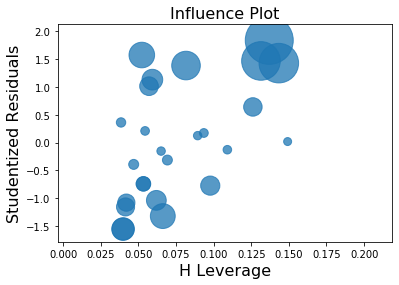

In [89]:
fig, ax = plt.subplots()
fig = sm.graphics.influence_plot(models.loc['Model 0']['results'], ax=ax, criterion="cooks")

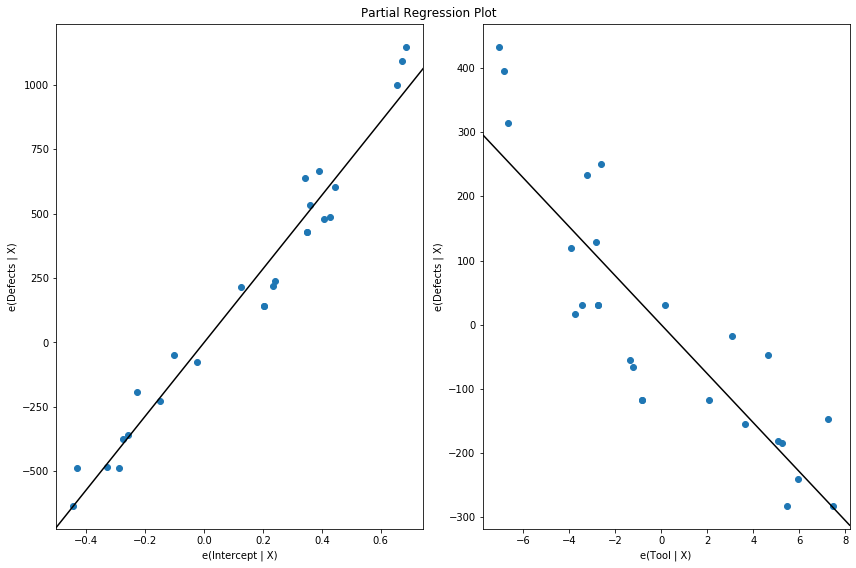

In [90]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(models.loc['Model 0', 'results'], fig=fig)

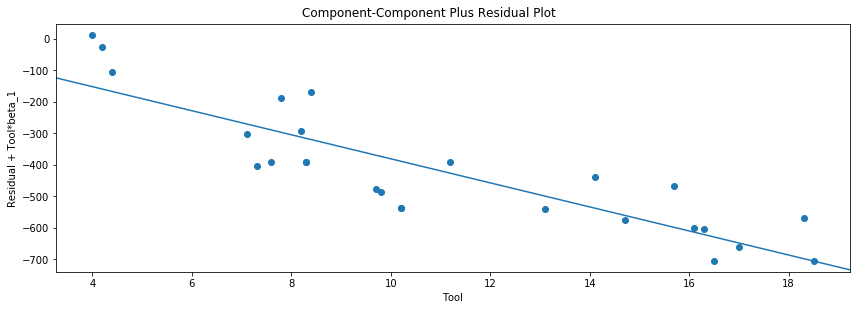

In [91]:
fig = plt.figure(figsize=(12, 8))
fig = sm.graphics.plot_ccpr_grid(models.loc['Model 0', 'results'], fig=fig)

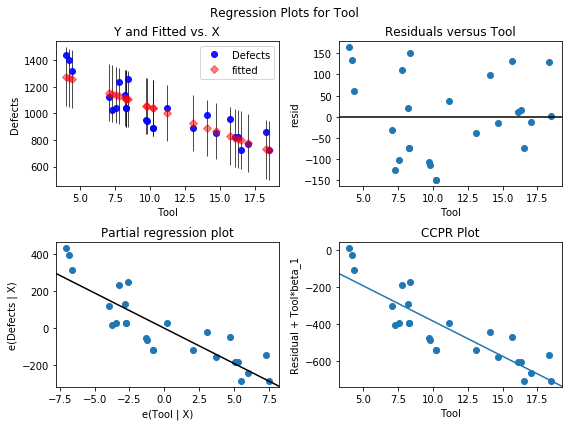

In [92]:
fig = ax = {}
for i, feature in enumerate(models.loc['Model 0', 'features']):
    fig[i] = plt.figure(figsize=(8,6))
    fig[i] = sm.graphics.plot_regress_exog(models.loc['Model 0', 'results'], feature, fig=fig[i])
# fig = sm.graphics.plot_regress_exog(models.loc[3, 'results'], "ln_Tool", fig=fig)

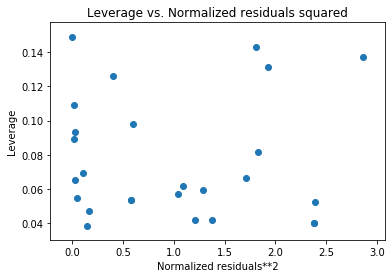

In [93]:
sm.graphics.plot_leverage_resid2(models.loc['Model 0', 'results']);

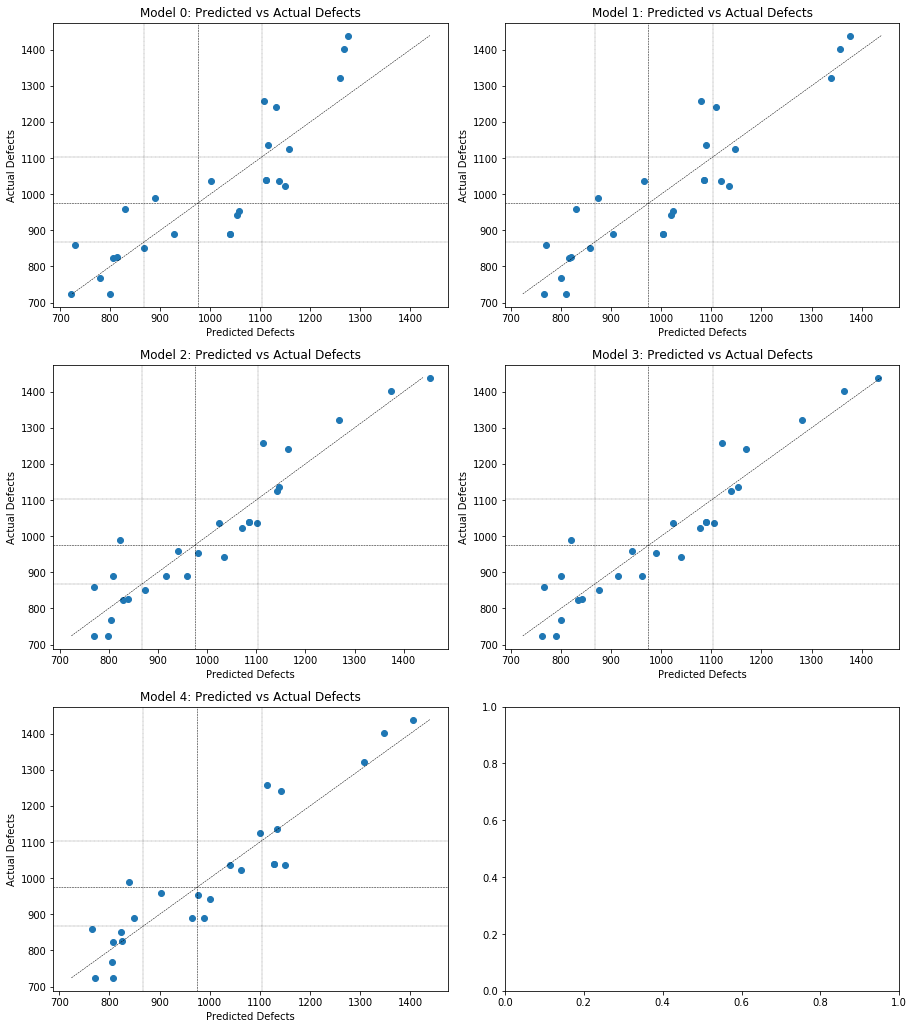

In [94]:
n_rows = int(np.ceil(n_models/2))

fig, ax = plt.subplots(n_rows, 2, figsize=(6.4*2, n_rows*4.8))
i = 0
for idx, model in models.iterrows():
    y = model['y']
    y_pred = model['y_pred']
    
    ax_t = ax[i//2, i%2]
    ax_t.plot(y_pred, y, 'o')
    ax_t.plot([min(y), max(y)], [min(y), max(y)], 'k--', linewidth=0.5)
    ax_t.set_title(f'{idx}: Predicted vs Actual Defects')
    ax_t.set_xlabel('Predicted Defects')
    ax_t.set_ylabel('Actual Defects')
    ax_t.axhline(np.median(y), c='k', ls='--', lw=0.5)
    ax_t.axhline(np.quantile(y, 0.25), c='k', ls='--', lw=0.25)
    ax_t.axhline(np.quantile(y, 0.75), c='k', ls='--', lw=0.25)
    ax_t.axvline(np.median(y), c='k', ls='--', lw=0.5)
    ax_t.axvline(np.quantile(y, 0.25), c='k', ls='--', lw=0.25)
    ax_t.axvline(np.quantile(y, 0.75), c='k', ls='--', lw=0.25)
    
    i += 1
plt.tight_layout()
plt.show()

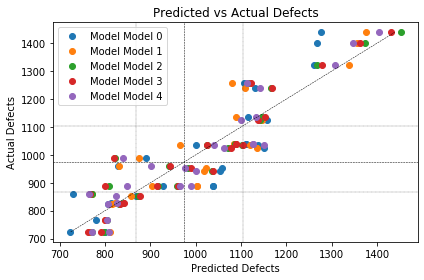

In [95]:
fig, ax = plt.subplots()
for i, model in models.iterrows():
    plt.plot(model['y_pred'], model['y'], 'o', label=f'Model {i}')

plt.plot([min(y), max(y)], [min(y), max(y)], 'k--', linewidth=0.5)
plt.title('Predicted vs Actual Defects')
plt.xlabel('Predicted Defects')
plt.ylabel('Actual Defects')
plt.axhline(np.median(y), c='k', ls='--', lw=0.5)
plt.axhline(np.quantile(y, 0.25), c='k', ls='--', lw=0.25)
plt.axhline(np.quantile(y, 0.75), c='k', ls='--', lw=0.25)
plt.axvline(np.median(y), c='k', ls='--', lw=0.5)
plt.axvline(np.quantile(y, 0.25), c='k', ls='--', lw=0.25)
plt.axvline(np.quantile(y, 0.75), c='k', ls='--', lw=0.25)
plt.legend()
plt.tight_layout()
plt.show()

# Linear regression (using statsmodels)

In [ ]:
import statsmodels.api as sm

In [ ]:
df.head(2)

## Model 1

In [ ]:
features = ['Tool', 'Age', 'Maintenance']
X = df[features]
# X = sm.add_constant(X.values) # add intercept feature --> deprecated
X.insert(0, 'Intercept', 1) # add intercept feature
y = df['Defects']

In [ ]:
mod = sm.OLS(y, X) # Ordinary Least Squares linear regression
res = mod.fit()

In [ ]:
y_pred = res.predict(X)

In [ ]:
res.summary()

In [ ]:
plt.plot(y_pred, y, '.')
plt.plot([min(y), max(y)], [min(y), max(y)], 'k--', linewidth=0.5)
plt.title('Predicted vs Actual Defects')
plt.xlabel('Predicted Defects')
plt.ylabel('Actual Defects')
plt.axhline(np.median(y), c='k', ls='--', lw=0.5)
plt.axvline(np.median(y), c='k', ls='--', lw=0.5)
plt.show()

## Model 2

In [ ]:
df['inv_Tool'] = 1/df['Tool']
df.head(2)

In [ ]:
features = ['inv_Tool', 'Age', 'Maintenance']
X = df[features]
# X = sm.add_constant(X.values) # add intercept feature --> deprecated
X.insert(0, 'Intercept', 1) # add intercept feature
y = df['Defects']

In [ ]:
mod = sm.OLS(y, X)
res = mod.fit()

In [ ]:
y_pred = res.predict(X)

In [ ]:
res.summary()

In [ ]:
plt.plot(y_pred, y, '.')
plt.plot([min(y), max(y)], [min(y), max(y)], 'k--', linewidth=0.5)
plt.title('Predicted vs Actual Defects')
plt.xlabel('Predicted Defects')
plt.ylabel('Actual Defects')
plt.axhline(np.median(y), c='k', ls='--', lw=0.5)
plt.axvline(np.median(y), c='k', ls='--', lw=0.5)
plt.show()

## Model 3

In [ ]:
features = ['ln_Tool', 'Age', 'inv_Maintenance']
X = df[features]
# X = sm.add_constant(X.values) # add intercept feature --> deprecated
X.insert(0, 'Intercept', 1) # add intercept feature
y = df['Defects']

In [ ]:
mod = sm.OLS(y, X) # Ordinary Least Squares linear regression
res = mod.fit()

In [ ]:
y_pred = res.predict(X)

In [ ]:
res.summary()

In [ ]:
plt.plot(y_pred, y, '.')
plt.plot([min(y), max(y)], [min(y), max(y)], 'k--', linewidth=0.5)
plt.title('Predicted vs Actual Defects')
plt.xlabel('Predicted Defects')
plt.ylabel('Actual Defects')
plt.axhline(np.median(y), c='k', ls='--', lw=0.5)
plt.axvline(np.median(y), c='k', ls='--', lw=0.5)
plt.show()

# Linear regression (using scikit-learn)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [ ]:
df.head(2)

## Model 1

In [ ]:
features = ['Tool', 'Age', 'Maintenance']
X = df[features].values
y = df['Defects'].values

In [ ]:
regressor = LinearRegression()  
regressor.fit(X, y)
y_pred = regressor.predict(X)

In [ ]:
coeff_df = pd.DataFrame([regressor.intercept_], ['Intercept'], columns=['Coefficient'])
coeff_df = coeff_df.append(pd.DataFrame(regressor.coef_, features, columns=['Coefficient']))
coeff_df

In [ ]:
MAE = metrics.mean_absolute_error(y, y_pred)
MSE = metrics.mean_squared_error(y, y_pred)
RMSE = np.sqrt(metrics.mean_squared_error(y, y_pred))
R2 = metrics.r2_score(y, y_pred)

print(f'Mean Absolute Error:     {MAE:7.2f}')
print(f'Mean Squared Error:      {MSE:7.2f}')
print(f'Root Mean Squared Error: {RMSE:7.2f}')
print(f'R^2 Score:               {R2:7.2f}')

print(f'RMSE/mean:\t{RMSE/y.mean():.1%}')
print(f'RMSE/range:\t{RMSE/(y.max()-y.min()):.1%}')

In [ ]:
plt.plot(y_pred, y, '.')
plt.plot([min(y), max(y)], [min(y), max(y)], 'k--', linewidth=0.5)
plt.title('Predicted vs Actual Defects')
plt.xlabel('Predicted Defects')
plt.ylabel('Actual Defects')
plt.axhline(np.median(y), c='k', ls='--', lw=0.5)
plt.axvline(np.median(y), c='k', ls='--', lw=0.5)
plt.show()

## Model 2

In [ ]:
df.head(2)

In [ ]:
df['inv_Tool'] = 1/df['Tool']
df.head(2)

In [ ]:
X = df[['inv_Tool', 'Age', 'Maintenance']].values
y = df['Defects'].values

In [ ]:
regressor = LinearRegression()  
regressor.fit(X, y)
y_pred = regressor.predict(X)

In [ ]:
coeff_df = pd.DataFrame(regressor.coef_, ['Tool', 'Age', 'Maintenance'], columns=['Coefficient'])  
coeff_df

In [ ]:
MAE = metrics.mean_absolute_error(y, y_pred)
MSE = metrics.mean_squared_error(y, y_pred)
RMSE = np.sqrt(metrics.mean_squared_error(y, y_pred))

print(f'Mean Absolute Error:     {MAE:7.2f}')
print(f'Mean Squared Error:      {MSE:7.2f}')
print(f'Root Mean Squared Error: {RMSE:7.2f}')

print(f'RMSE/mean:\t{RMSE/y.mean():.1%}')
print(f'RMSE/range:\t{RMSE/(y.max()-y.min()):.1%}')

In [ ]:
plt.plot(y_pred, y, '.')
plt.plot([min(y), max(y)], [min(y), max(y)], 'k--', linewidth=0.5)
plt.title('Predicted vs Actual Defects')
plt.xlabel('Predicted Defects')
plt.ylabel('Actual Defects')
plt.axhline(np.median(y), c='k', ls='--', lw=0.5)
plt.axvline(np.median(y), c='k', ls='--', lw=0.5)
plt.show()

# Linear regression with test data

In [ ]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [ ]:
X = df[['Tool', 'Age', 'Maintenance']].values
y = df['Defects'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

In [ ]:
coeff_df = pd.DataFrame(regressor.coef_, ['Tool', 'Age', 'Maintenance'], columns=['Coefficient'])  
coeff_df

In [ ]:
y_pred = regressor.predict(X_test)

In [ ]:
df_r = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_r

In [ ]:
df_r.plot(kind='bar')
plt.show()

In [ ]:
MAE = metrics.mean_absolute_error(y_test, y_pred)
MSE = metrics.mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print(f'Mean Absolute Error:     {MAE:7.2f}')
print(f'Mean Squared Error:      {MSE:7.2f}')
print(f'Root Mean Squared Error: {RMSE:7.2f}')

print(f'RMSE/mean:\t{RMSE/y_test.mean():.1%}')
print(f'RMSE/range:\t{RMSE/(y_test.max()-y_test.min()):.1%}')

In [ ]:
y_pred_all = regressor.predict(X)
plt.plot(y_pred_all, y, '.', label='All')
plt.plot(y_pred, y_test, '.', label='Test')
plt.plot([min(y), max(y)], [min(y), max(y)], 'k--', linewidth=0.5)
plt.title('Predicted vs Actual Defects')
plt.xlabel('Predicted Defects')
plt.ylabel('Actual Defects')
plt.axhline(np.median(y), c='k', ls='--', lw=0.5)
plt.axvline(np.median(y), c='k', ls='--', lw=0.5)
plt.legend()
plt.show()